In [1]:
#Importing necessary modules
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

In [2]:
#Load kaggle dataset into dataframe
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


In [3]:
#Examine first few rows of dataframe
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
#Label count for each label
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

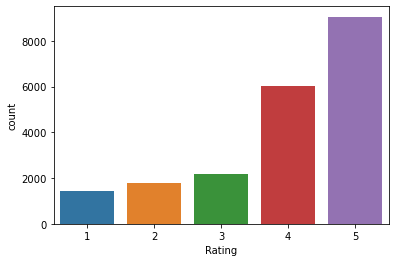

In [5]:
#Visualzing the label count
sns.countplot(df.Rating)

In [6]:
#converting review text to lower case

dataset = df['Review'].str.lower()

In [7]:
#removing the punctuation marks

PUNCTUATION = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION))

df["Review"] = df["Review"].apply(lambda sentence: remove_punctuation(sentence))
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4 experience hotel monaco seatt...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


In [8]:
#stop words list
stop_words_list = stopwords.words('english')

In [9]:
#removing the stop words from the review text
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words_list])

df["Review"] = df["Review"].apply(lambda sentence: remove_stopwords(sentence))
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms 4 experience hotel monaco seattle g...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


In [10]:
#removing blank characters from the review text
def remove_blankCharacters(text):
    return " ".join([word for word in str(text).split() if word not in ['',' ']])

df["Review"] = df["Review"].apply(lambda sentence: remove_blankCharacters(sentence))
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms 4 experience hotel monaco seattle g...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


In [26]:
#Calculating average length of the sentences
def calculate_length(text):
    words = [word for word in str(text).split()]
    return len(words)

df["length"] = df["Review"].apply(lambda sentence: calculate_length(sentence))
avg_len = df["length"].mean()
df.head()
print("Average length of the sentences is {}".format(avg_len))

Average length of the sentences is 100.67946903518617


In [38]:
#Calculating maximum and minimum length of review sentences
maximum = df['length'].max()
minimum = df['length'].min()

print('maximum length is {}, minimum length is {}'.format(maximum,minimum))

1931
['honest', 'review', 'visit', '5/21-5/28', 'let', 'begin', 'saying', 'heard', 'secrets', 'couple', 'work', 'went', 'resort', 'year', 'returned', 'raving', 'experiences,', 'all-inclusive', 'regular', 'cruise', 'traveler', 'past', '4', 'years', 'decided', 'based', 'word-of-mouth', 'secrets', 'place', 'try.i', 'read', 'posts', 'site', 'daily,', 'review', 'written', 'resort', 'scoured', 'eyes,', 'reviews', 'gotten', 'good', 'suspected', 'staff', 'secrets', 'writing,', 'fact', 'person', 'posted', 'review', 'claimed', 'saw', 'staff', 'members', 'reading', 'posting', 'forum,', 'ca', "n't", 'say', 'stay', 'excellence', 'club', 'saw', 'type', 'activity', 'going', 'wo', "n't", 'past', 'hotel', 'ratings', 'high', 'posting', 'positive', 'reviews.in', 'case', 'read', 'totally', 'honest', 'review', 'secrets', 'felt', 'all-inclusive', 'experience,', 'end', 'review', 'include', 'link', 'photo', 'page', 'think', 'enjoy.i', 'booked', 'trip', 'judy', 'maria', 'travel', 'internet,', 'no', 'travel', '

In [13]:
#Preparing the labels and the train data
le = LabelEncoder()
Y = le.fit_transform(df.Rating)
Y = Y.reshape(-1,1)
X = df['Review'].tolist()

In [14]:
#splitting the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0, stratify=Y)

In [15]:
print('No. of train samples: {}'.format(len(X_train)))
print('No. of train labels: {}\n'.format(len(Y_train)))
print('No. of test samples: {}'.format(len(X_test)))
print('No. of test labels: {}'.format(len(Y_test)))

No. of train samples: 16392
No. of train labels: 16392

No. of test samples: 4099
No. of test labels: 4099


In [16]:
#convert train labels into one hot vectors
Y_train_one_hot_labels = to_categorical(Y_train)

In [17]:
#Tokenizing, converting to sequences and padding the train data 
max_words = 5000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [18]:
#model
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = Conv1D(128, 5, activation='relu')(layer)
layer = LSTM(128)(layer)
layer = Dense(128, name='FC1')(layer)
layer = Dropout(0.1)(layer)
layer = Dense(64, name='FC2')(layer)
layer = Dense(5, name='out_layer')(layer)
layer = Activation('softmax')(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           250000    
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 128)          32128     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 64)               

In [19]:
#Training

model.fit(sequences_matrix,Y_train_one_hot_labels,batch_size=128,epochs=5,
          validation_split=0.1)

Epoch 1/5
116/116 [==============================] - 40s 348ms/step - loss: 1.1785 - accuracy: 0.4808 - val_loss: 0.9926 - val_accuracy: 0.5659
Epoch 2/5
116/116 [==============================] - 40s 347ms/step - loss: 0.9287 - accuracy: 0.5752 - val_loss: 0.9595 - val_accuracy: 0.5720
Epoch 3/5
116/116 [==============================] - 39s 337ms/step - loss: 0.8119 - accuracy: 0.6392 - val_loss: 0.9283 - val_accuracy: 0.5878
Epoch 4/5
116/116 [==============================] - 40s 344ms/step - loss: 0.7053 - accuracy: 0.6986 - val_loss: 0.9490 - val_accuracy: 0.5915
Epoch 5/5
116/116 [==============================] - 40s 342ms/step - loss: 0.6100 - accuracy: 0.7374 - val_loss: 1.0437 - val_accuracy: 0.5780


In [20]:
#convert test data into sequences and padding them
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [21]:
#Calculating the accuracy of the model
Y_test_one_hot_labels = to_categorical(Y_test)
accr = model.evaluate(test_sequences_matrix,Y_test_one_hot_labels)

129/129 [==============================] - 5s 41ms/step - loss: 1.0695 - accuracy: 0.5772


In [25]:
print('Loss: {:0.3f}  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Loss: 1.070  Accuracy: 0.577
